# Takehome Challenge - Data Analyst
### November 4, 2022

---

**Timothy Del Green**<br>
1-256-335-0378<br>
tdgreen@outlook.com<br>
https://www.linkedin.com/in/timothy-del-green<br>
https://github.com/delgreen/data_science_portfolio<br>

---

# INSTRUCTIONS
- Please answer the following questions with the code language provided
- Feel free to add more cells when necessary for each question than just the one provided
- For python code, the code cells should be executed and the final cell output should display the answer to the question
- For SQL, the answer cells are set to "Markdown" so please execuse as a markdown to ensure the code stays saved

The test consists of 11 questions/prompts and for 9 of those we’d like you write out code in Python, as well as SQL. 

- The first cell asks you to import the data and we’re expecting you to only import with Python, and 
- the last cell asks you to make a visualization and we’re expecting you to only do this in Python. 
- We’re making a guess that you’ll use Pandas throughout the notebook, but if there are other libraries you’d like to use, feel free. 
- For your answers in SQL, since there’s no database to query, we’ve got markdown cells. Please write the SQL answers in those markdown cells. Some people ask us what flavor of SQL they should write in, and you can assume that if there was a database, it would be PostgreSQL.

# Import headers and the 3 data files

In [99]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pandasql import sqldf
from matplotlib.ticker import FuncFormatter

%matplotlib inline


In [123]:
def transactions_dataset() -> pd.DataFrame:
    # Path to current working directory
    p = Path('.')
    
    # Customer Data
    customers_data = pd.read_csv(p / 'customers.csv')

    # Orders Data
    orders_data = pd.read_csv(p / 'orders.csv')

    # Prices Data
    prices_data = pd.read_csv(p / 'prices.csv')
    
    return(
        orders_data
            .merge(
                customers_data,
                on='customer_name',
                how='left',
                validate='m:1',
            )
            .merge(
                prices_data,
                on='product',
                how='left',
                validate='m:1'
            )
            .fillna({
                **{col : 0 for col in [
                    'quantity',
                    'price',
                ]}
            })
            .astype({
                **{col : int for col in [
                    'quantity',
                ]},
                **{col : float for col in [
                    'price',
                ]},
                **{col : str for col in [
                    'zip_code',
                ]}
            })
            .assign(
                date = lambda df_ : pd.to_datetime(df_['date']),

                # The revenue for each order is equal to the product of the quantity times the price
                revenue = lambda df_ : df_['quantity'] * df_['price']
            )
            .drop_duplicates()
    )

dataset = transactions_dataset()

dataset.head()


,order_number,customer_name,product,quantity,date,zip_code,price,revenue
0,1,carreca01,y3,1,2017-12-09,90101,81.46,81.46
1,2,handdo01,y3,1,2017-11-27,90289,81.46,81.46
2,3,gearyhu01,x9,1,2017-12-05,60048,89.50,89.50
3,4,ginnti01,x6,4,2017-10-01,90289,20.65,82.60
4,5,hoffmfr01,y6,3,2017-11-13,53987,81.24,243.72


# What is the total revenue generated in the entire data set?

python code

In [101]:
np.sum(dataset['revenue'])


85221.28

SQL code

select sum(revenue) from table

In [124]:
q_1 = """

SELECT
    SUM(A.revenue) AS total_revenue
FROM
    dataset as A

"""

(sqldf(q_1, globals())['total_revenue'][0].round(2))


85221.28

# Summarize total revenue by product

python code

In [103]:
(
    dataset
        .groupby('product')
        .agg(total_revenue = pd.NamedAgg(column='revenue', aggfunc='sum'))
        .sort_values(by='product')
        .reset_index()
)


,product,total_revenue
0,x1,288.54
1,x10,2284.45
2,x11,532.08
3,x12,767.88
4,x2,574.86
5,x3,958.68
6,x4,255.99
7,x5,448.72
8,x6,2994.25
9,x7,943.50


sql code

In [104]:
q_2 = """

SELECT
    A.product
    ,SUM(A.revenue) AS total_revenue
FROM
    dataset AS A
GROUP BY
    A.product
ORDER BY
    A.product

"""

sqldf(q_2, globals())


,product,total_revenue
0,x1,288.54
1,x10,2284.45
2,x11,532.08
3,x12,767.88
4,x2,574.86
5,x3,958.68
6,x4,255.99
7,x5,448.72
8,x6,2994.25
9,x7,943.50


# What customer(s) placed the most orders? How many?

python code

In [105]:
(
    dataset
        .groupby('customer_name')
        .agg(order_count = pd.NamedAgg(column='order_number', aggfunc='count'))
        .query('order_count == order_count.max()')
        .reset_index()
)


,customer_name,order_count
0,casilal01,18


sql code

In [106]:
q_3 = """

WITH
    ORDER_COUNT_TABLE AS (
        SELECT
            A.customer_name
            ,COUNT(A.order_number) AS order_count
            ,RANK() OVER(ORDER BY COUNT(A.order_number) DESC) AS order_rank
        FROM
            dataset AS A
        GROUP BY
            A.customer_name
    )
SELECT
    customer_name
    ,order_count
FROM
    ORDER_COUNT_TABLE
WHERE
    order_rank = 1
    
"""

sqldf(q_3, globals())


,customer_name,order_count
0,casilal01,18


# What zip code had the most revenue? How much?

python code

In [107]:
(
    dataset
        .groupby('zip_code')
        .agg(total_revenue = pd.NamedAgg(column='revenue', aggfunc='sum'))
        .query('total_revenue == total_revenue.max()')
        .reset_index()
)


,zip_code,total_revenue
0,90289,18979.42


SQL code

In [108]:
q_4 = """

WITH
    REVENUE_TABLE AS (
        SELECT 
            A.zip_code
            ,SUM(A.revenue) AS total_revenue
            ,RANK() OVER(ORDER BY SUM(A.revenue) DESC) AS revenue_rank
        FROM
            dataset AS A
        GROUP BY
            A.zip_code
    )
SELECT
    zip_code
    ,total_revenue
FROM 
    REVENUE_TABLE
WHERE
    revenue_rank = 1

"""

sqldf(q_4, globals())


,zip_code,total_revenue
0,90289,18979.42


# How many units of product y6 were ordered by customers in zip code 60062 between 11/10/2017 and 11/30/2017, inclusively?

python code

In [109]:
(
    dataset[dataset['date'].isin(pd.date_range(start='11/10/2017', end='11/30/2017'))]
        .query('product == "y6" and zip_code == "60062"')
        .groupby(['product', 'zip_code'])
        .agg(total_units_ordered = pd.NamedAgg(column='quantity', aggfunc='sum'))
        .reset_index()
)


,product,zip_code,total_units_ordered
0,y6,60062,13


sql code

In [110]:
q_5 = """

SELECT
    A.product
    ,A.zip_code
    ,SUM(A.quantity) AS total_units_ordered
FROM
    dataset AS A
WHERE
        A.date BETWEEN '2017-11-10' AND '2017-11-30'
    AND A.product = 'y6'
    AND A.zip_code = '60062'
GROUP BY
    A.product
    ,A.zip_code

"""

sqldf(q_5, globals())


,product,zip_code,total_units_ordered
0,y6,60062,13


# What product had the largest mean order quantity? What is the mean?

python code

In [111]:
(
    dataset
        .groupby('product')
        .agg(mean_order_qty = pd.NamedAgg(column='quantity', aggfunc='mean'))
        .query('mean_order_qty == mean_order_qty.max()')
        .reset_index()
)


,product,mean_order_qty
0,x10,3.588235


sql code

In [112]:
q_6 = """

WITH
    MEAN_QTY_TABLE AS (
        SELECT
            A.product
            ,AVG(A.quantity) AS mean_order_qty
            ,RANK() OVER (ORDER BY AVG(A.quantity) DESC) AS mean_order_qty_rank
        FROM 
            dataset AS A
        GROUP BY
            A.product
    )
SELECT
    product
    ,mean_order_qty
FROM 
    MEAN_QTY_TABLE
WHERE
    mean_order_qty_rank = 1

"""

sqldf(q_6, globals())


,product,mean_order_qty
0,x10,3.588235


# What product(s) had the fewest orders?  How many? How about the most?  How many?

python code

In [113]:
# This table represents the products with the fewest and most orders,
#   where two product numbers ranked with the lowest count of orders

(
    dataset
        .groupby('product')
        .agg(order_count = pd.NamedAgg(column='order_number', aggfunc='count'))
        .query('order_count == order_count.max() or order_count == order_count.min()')
        .reset_index()
)


,product,order_count
0,x11,3
1,x5,3
2,y6,82


sql code

In [114]:
# This table represents the products with the fewest and most orders,
#   where two product numbers ranked with the lowest count of orders

q_7 = """

WITH
    ORDER_COUNT_TABLE AS (
        SELECT
            A.product
            ,COUNT(A.order_number) AS order_count
            ,RANK() OVER(ORDER BY COUNT(A.order_number)) AS order_rank
        FROM
            dataset AS A
        GROUP BY
            A.product
    )
SELECT
    product
    ,order_count
FROM 
    ORDER_COUNT_TABLE
WHERE 
        order_rank = (SELECT MIN(order_rank) FROM ORDER_COUNT_TABLE) 
    OR  order_rank = (SELECT MAX(order_rank) FROM ORDER_COUNT_TABLE)

"""

sqldf(q_7, globals())


,product,order_count
0,x11,3
1,x5,3
2,y6,82


# What is the shortest and longest duration in days between orders placed by customer 'westle01'?

python code

In [115]:
# This table represents both the shortest and longest durations.
# There is a case where two orders are made on the same day, reuslting in '0 days' of 
#   of duration between each order.

(
    dataset[['order_number', 'customer_name', 'date']]
        .query('customer_name == "westle01"')
        .sort_values(by='date')
        .assign(
            duration = lambda df_ : df_['date'] - df_['date'].shift()
        )
        .query('duration == duration.max() or duration == duration.min()')
        .reset_index(drop=True)
)


,order_number,customer_name,date,duration
0,173,westle01,2017-10-16,0 days
1,16,westle01,2017-11-10,22 days


sql code

In [116]:
# This table represents both the shortest and longest durations.
# There is a case where two orders are made on the same day, reuslting in '0 days' of 
#   of duration between each order.

q_8 = """

WITH
    DURATION_TABLE AS (
        SELECT
            A.order_number
            ,A.customer_name
            ,DATE(A.date) AS date
            ,JULIANDAY(DATE(A.date)) 
                - JULIANDAY(LAG(A.date, 1) OVER(ORDER BY A.date)) AS duration
        FROM 
            dataset AS A
        WHERE
            A.customer_name = 'westle01'
    )
SELECT
    order_number
    ,customer_name
    ,date
    ,CAST(duration AS INTEGER) || ' days' as duration
FROM
    DURATION_TABLE
WHERE
        duration = (SELECT MIN(duration) FROM DURATION_TABLE)
    OR  duration = (SELECT MAX(duration) FROM DURATION_TABLE)

"""

sqldf(q_8, globals())


,order_number,customer_name,date,duration
0,173,westle01,2017-10-16,0 days
1,16,westle01,2017-11-10,22 days


# How many customers have the letter 'w' in their customer_id?  Who are they?

python code

In [127]:
# Assuming that 'customer_id' in this question is referring to 'customer_name'

print(len(dataset[dataset['customer_name'].str.contains('[wW]')]['customer_name'].unique()))

print(dataset[dataset['customer_name'].str.contains('[wW]')]['customer_name'].sort_values().unique())


6
['newmafr01' 'sweenha01' 'wallide01' 'wellsca01' 'westle01' 'whitemy01']


sql code

In [118]:
# Assuming that 'customer_id' in this question is referring to 'customer_name'

q_9 = """

SELECT
    A.customer_name
    ,COUNT(A.customer_name) OVER() as customer_count
FROM
    dataset AS A
WHERE
    A.customer_name LIKE '%w%'
GROUP BY
    A.customer_name
ORDER BY
    A.customer_name

"""

print(sqldf(q_9, globals())['customer_count'][0])

print(np.array(sqldf(q_9, globals())['customer_name']))


6
['newmafr01' 'sweenha01' 'wallide01' 'wellsca01' 'westle01' 'whitemy01']


# Generate a plot and a chart of revenue by day of week
- please use one of the following (i.e. make it fancier than matplotlib)
- plotnine
- seaborn
- bokeh
- plotly
- anything that is not just standard matplotlib

In [119]:
(
    dataset
        .assign(
            weekday_name = lambda df_ : df_['date'].dt.day_name(),

            weekday_number = lambda df_ : df_['date'].dt.weekday
        )
        # Group by weekday number, then name. Ensures correct sorting in axes.
        .groupby(['weekday_number', 'weekday_name'])
        .agg(total_revenue = pd.NamedAgg(column='revenue', aggfunc='sum'))
        .reset_index()
)


,weekday_number,weekday_name,total_revenue
0,0,Monday,13241.73
1,1,Tuesday,10388.39
2,2,Wednesday,10125.22
3,3,Thursday,11409.19
4,4,Friday,13803.71
5,5,Saturday,12515.11
6,6,Sunday,13737.93


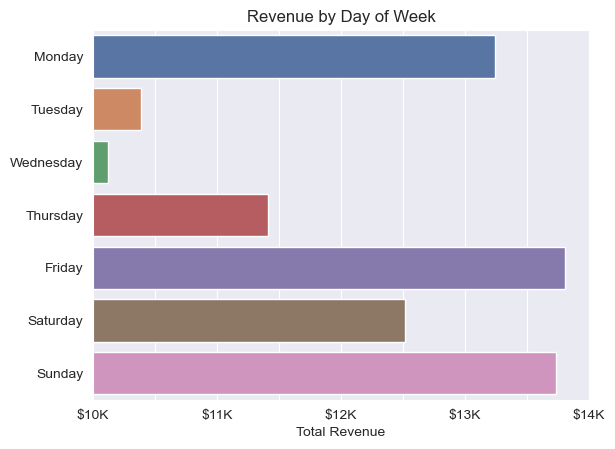

In [120]:
%%capture --no-display

def revenue_barplot(df: pd.DataFrame) -> mpl.figure.Figure:
    def large_quantity(x, pos):
        # Formats values over 100000
        return '${:1.0f}K'.format(x*1e-3)
    
    def xtick_density(axes):
        # Reduce the x-axis tick density
        for index, label in enumerate(axes.get_xticklabels()):
            if index % 2 == 0:
                label.set_visible(True)
            else:
                label.set_visible(False)
    
    sns.set_style('darkgrid')

    sns.set_palette('deep')

    fig, ax = plt.subplots()

    weekday_revenue_data = (
        df
            .assign(
                weekday_name = lambda df_ : df_['date'].dt.day_name(),

                weekday_number = lambda df_ : df_['date'].dt.weekday
                
            )
            # Group by weekday number, then name. Ensures correct sorting in axes.
            .groupby(['weekday_number', 'weekday_name'])
            .agg(total_revenue = pd.NamedAgg(column='revenue', aggfunc='sum'))
            .reset_index()
    )

    sns.barplot(
        data=weekday_revenue_data,
        x='total_revenue',
        y='weekday_name',
        ax=ax,
    )

    ax.set(
        title='Revenue by Day of Week',
        xlabel='Total Revenue',
        ylabel='',
    )
    

    # Change x-axis limits to make bars more meaningfgul
    ax.set_xlim([10000, 14000])
    
    # Apply monetary formatting to x-axis
    formatter = FuncFormatter(large_quantity)
    
    ax.xaxis.set_major_formatter(formatter)
    
    # Redue x-axis tick density
    xtick_density(ax)
    
    # # Apply bar labels 
    # ax.bar_label(ax.containers[0])

    return fig


weekday_revenue_barplot = revenue_barplot(dataset)


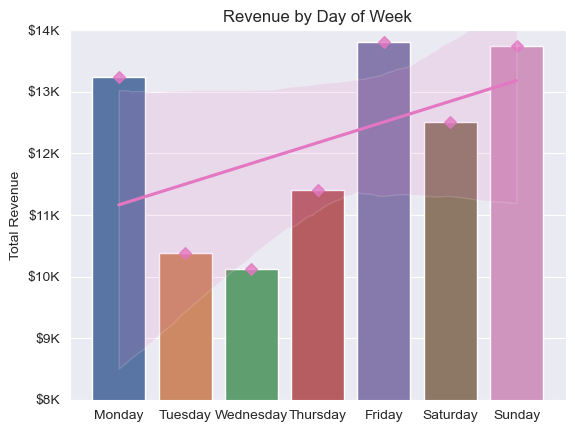

In [121]:
%%capture --no-display

def revenue_regplot(df: pd.DataFrame) -> mpl.figure.Figure:
    def large_quantity(x, pos):
        # Formats values over 100000
        return '${:1.0f}K'.format(x*1e-3)

    sns.set_style('darkgrid')

    sns.set_palette('deep')

    fig, ax = plt.subplots()

    weekday_revenue_data = (
        df
            .assign(
                weekday_name = lambda df_ : df_['date'].dt.day_name(),

                weekday_number = lambda df_ : df_['date'].dt.weekday
            )
            # Group by weekday number, then name. Ensures correct sorting in axes.
            .groupby(['weekday_number', 'weekday_name'])
            .agg(total_revenue = pd.NamedAgg(column='revenue', aggfunc='sum'))
            .reset_index()
    )

    sns.barplot(
        data=weekday_revenue_data,
        x='weekday_name',
        y='total_revenue',
        ax=ax,
    )

    sns.regplot(
        data=weekday_revenue_data,
        x='weekday_number',
        y='total_revenue',
        color='tab:pink',
        marker='D',
        ax=ax,
    )
    
    ax.set(
        title='Revenue by Day of Week',
        xlabel='',
        ylabel='Total Revenue',
    )

    # Change y-axis limits to make bars more meaningfgul
    ax.set_ylim([8000, 14000])

    # Apply monetary formatting to y-axis
    formatter = FuncFormatter(large_quantity)

    ax.yaxis.set_major_formatter(formatter)

    return fig


weekday_revenue_regplot = revenue_regplot(dataset)
